
# Методы улучшения точности точности архитектур в PyTorch

## Загрузка необходимых библиотек

In [ ]:
pip install torchsummary

Note: you may need to restart the kernel to use updated packages.


In [ ]:
import random
import numpy as np
import matplotlib.pyplot as plt

import os
import copy
import time

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data

import torchvision
from torchvision import transforms, datasets
import torchvision.transforms as T

from torchsummary import summary

from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

from tqdm.notebook import tqdm, trange

import pandas as pd



def torch_stats():
    torch_version = ".".join(torch.__version__.split(".")[:2])
    print('torch version:',torch_version)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print('Using device:', device)
    dtype = torch.float32

    if device.type == 'cuda':
        cuda_version  = torch.__version__.split("+")[-1]
        print("cuda: ", cuda_version)

        torch.set_default_tensor_type(torch.cuda.FloatTensor)
        print('Cuda is available:',torch.cuda.is_available())

        n_devices = torch.cuda.device_count()
        print('number of devices: %d'%(n_devices))

        for cnt_device in range(n_devices):
            print(torch.cuda.get_device_name(cnt_device))
            print('Memory Usage:')
            print('Allocated:',
                  round(torch.cuda.memory_allocated(cnt_device)/1024**3,1),'GB')
            print('Cached:   ',
                  round(torch.cuda.memory_reserved(cnt_device)/1024**3,1), 'GB')


    torch.set_default_dtype(dtype) # float32
    print('default data type:',dtype)

    num_workers=os.cpu_count()
    print ('available number of workers (CPU cores):',num_workers)

    return device, dtype, num_workers
#-------------------------------
def torch_seed(seed = 42, deterministic = True):
    random.seed(seed) # random and transforms
    np.random.seed(seed) #numpy
    torch.manual_seed(seed) #cpu
    torch.cuda.manual_seed(seed) #gpu
    torch.backends.cudnn.deterministic=deterministic #cudnn



device, dtype, num_workers = torch_stats()
torch_seed(seed = 35, deterministic = True)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


torch version: 2.0
Using device: cuda
cuda:  2.0.0
Cuda is available: True
number of devices: 2
Tesla T4
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB
Tesla T4
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB
default data type: torch.float32
available number of workers (CPU cores): 4


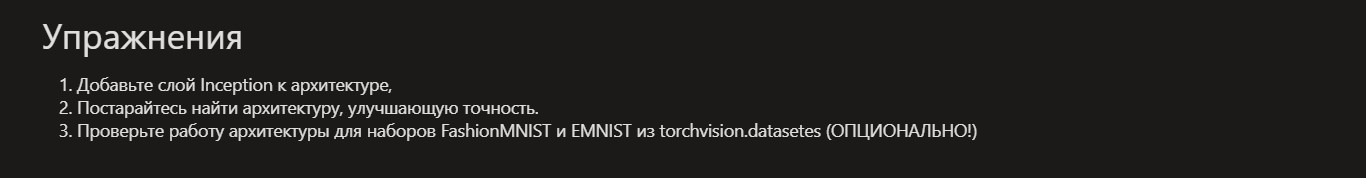

## 1. Добавить слой Inception к архитектуре LeNet

Создадим блок Inception

In [ ]:
class InceptionModule(nn.Module):
    def __init__(self, in_channels, out1x1, red3x3, out3x3, red5x5, out5x5, out1x1pool):
        super(InceptionModule, self).__init__()

        self.branch1 = nn.Conv2d(in_channels, out1x1, kernel_size=1)

        self.branch2 = nn.Sequential(
            nn.Conv2d(in_channels, red3x3, kernel_size=1),
            nn.ReLU(),
            nn.Conv2d(red3x3, out3x3, kernel_size=3, padding=1)
        )

        self.branch3 = nn.Sequential(
            nn.Conv2d(in_channels, red5x5, kernel_size=1),
            nn.ReLU(),
            nn.Conv2d(red5x5, out5x5, kernel_size=5, padding=2)
        )

        self.branch4 = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
            nn.Conv2d(in_channels, out1x1pool, kernel_size=1)
        )

    def forward(self, x):

        in_channels = x.size(1)

        out1 = self.branch1(x)
        out2 = self.branch2(x)
        out3 = self.branch3(x)
        out4 = self.branch4(x)


        return torch.cat([out1, out2, out3, out4], 1)

Добавим InceptionModule в конец архитектуры LeNet

In [ ]:
class LeNetWithInception(nn.Module):
    def __init__(self, in_channels, n_classes):
        super(LeNetWithInception, self).__init__()

        self.in_channels = in_channels
        self.n_classes   = n_classes

        # Convolution with stride 2
        self.conv1   = nn.Conv2d(in_channels  = self.in_channels,
                                 out_channels = 6,
                                 kernel_size  = 5,
                                 stride       = 2,
                                 padding      = 2,
                                 dilation     = 1)


        # Cascade Convolution
        conv2_1   = nn.Conv2d(in_channels     = 6,
                                 out_channels = 16,
                                 kernel_size  = 3,
                                 padding      = 1)

        conv2_2   = nn.Conv2d(in_channels     = 16,
                                 out_channels = 16,
                                 kernel_size  = 3,
                                 padding      = 1)

        self.conv2 = nn.Sequential(conv2_1,
                                   nn.ReLU(),
                                   conv2_2,
                                   nn.BatchNorm2d(16))

        # Spatially-Separable Convolution
        conv3_1 = nn.Conv2d(in_channels  = 16,
                            out_channels = 32,
                            kernel_size  = (3,1),
                            padding      = 1)

        conv3_2 = nn.Conv2d(in_channels  = 32,
                            out_channels = 32,
                            kernel_size  = (1,3),
                            padding      = 1)

        self.conv3 = nn.Sequential(conv3_1,
                                   nn.ReLU(),
                                   conv3_2)

        self.inception = InceptionModule(in_channels=64, out1x1=32, red3x3=16, out3x3=32, red5x5=16, out5x5=32, out1x1pool=64)

        # self.inception = InceptionModule(in_channels=32)

        # Residual bottleneck layer
        conv1x1_1 = nn.Conv2d(in_channels  = 32,
                              out_channels = 16,
                              kernel_size  = 1)

        conv3x3  = nn.Conv2d(in_channels  = 16,
                             out_channels = 16,
                             kernel_size  = 3,
                             padding      = 1)

        conv1x1_2 = nn.Conv2d(in_channels  = 16,
                              out_channels = 32,
                              kernel_size  = 1)

        self.main_block = nn.Sequential(conv1x1_1,
                                        nn.BatchNorm2d(16),
                                        nn.ReLU(),
                                        conv3x3,
                                        nn.BatchNorm2d(16),
                                        nn.ReLU(),
                                        conv1x1_2,
                                        nn.BatchNorm2d(32))

        # Depthwise Separable Convolution
        depth_conv = nn.Conv2d(in_channels  = 32,
                               out_channels = 32,
                               kernel_size  = 3,
                               groups       = 16,
                               padding      = 1)

        point_conv = nn.Conv2d(in_channels  = 32,
                               out_channels = 64,
                               kernel_size  = 1)

        self.conv5 = nn.Sequential(depth_conv,
                                   nn.BatchNorm2d(32),
                                   nn.ReLU(),
                                   point_conv)


        #normalization
        self.bn1 = nn.BatchNorm2d(6)

        # pooling
        self.maxpool = nn.MaxPool2d(kernel_size = 2,
                                    stride      = 2)

        # Global Average Pooling
        self.gap = nn.AdaptiveAvgPool2d((1,1))

        # classification
        self.fc_out = nn.Linear(in_features = 160,
                                out_features = self.n_classes)

    def conv_reduce_channels(self, x):
        return nn.Conv2d(x.shape[1], 64, kernel_size=1)(x)

    def forward(self, x):

        # 1-st layer
        x = self.conv1(x)
        x = self.bn1(x)
        x = torch.relu(x)

        #2-nd layer
        x = self.conv2(x)
        x = torch.relu(x)
        x = self.maxpool(x)

        #3-nd layer
        x = self.conv3(x)
        x = torch.relu(x)
        x = self.maxpool(x)


        # x = self.inception(x)
        # x = torch.relu(x)
        # x = self.conv_reduce_channels(x)


        # print(x.shape[1])
        #4-th layer
        h = self.main_block(x)
        x = x+h
        x = torch.relu(x)


        #5-th layer
        x = self.conv5(x)
        x = torch.relu(x)
        # print(x.shape)

        x = self.inception(x)
        x = torch.relu(x)
        # x = self.conv_reduce_channels(x)
        # print(x.shape)

        # 1-st fc layer
        x = self.gap(x)
        h = torch.flatten(x, 1)
        x = self.fc_out(h)

        return x#torch.softmax(x, dim=1)

In [ ]:
model =LeNetWithInception(3,10)

# from torchsummary import summary
summary(model, input_size = (3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 16, 16]             456
       BatchNorm2d-2            [-1, 6, 16, 16]              12
            Conv2d-3           [-1, 16, 16, 16]             880
              ReLU-4           [-1, 16, 16, 16]               0
            Conv2d-5           [-1, 16, 16, 16]           2,320
       BatchNorm2d-6           [-1, 16, 16, 16]              32
         MaxPool2d-7             [-1, 16, 8, 8]               0
            Conv2d-8            [-1, 32, 8, 10]           1,568
              ReLU-9            [-1, 32, 8, 10]               0
           Conv2d-10           [-1, 32, 10, 10]           3,104
        MaxPool2d-11             [-1, 32, 5, 5]               0
           Conv2d-12             [-1, 16, 5, 5]             528
      BatchNorm2d-13             [-1, 16, 5, 5]              32
             ReLU-14             [-1, 1

In [ ]:
params = list(model.named_parameters())

# print(params)
for idx in range(len(params)):
    print(params[idx][0],'\t', params[idx][1].size())
print('\n',10*'--')
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print('Number of trainable parameters for the model: %d' % (num_params))

num_params = sum(p.numel() for p in model.parameters() )
print('Number of all parameters for the model: %d' % (num_params))

conv1.weight 	 torch.Size([6, 3, 5, 5])
conv1.bias 	 torch.Size([6])
conv2.0.weight 	 torch.Size([16, 6, 3, 3])
conv2.0.bias 	 torch.Size([16])
conv2.2.weight 	 torch.Size([16, 16, 3, 3])
conv2.2.bias 	 torch.Size([16])
conv2.3.weight 	 torch.Size([16])
conv2.3.bias 	 torch.Size([16])
conv3.0.weight 	 torch.Size([32, 16, 3, 1])
conv3.0.bias 	 torch.Size([32])
conv3.2.weight 	 torch.Size([32, 32, 1, 3])
conv3.2.bias 	 torch.Size([32])
inception.branch1.weight 	 torch.Size([32, 64, 1, 1])
inception.branch1.bias 	 torch.Size([32])
inception.branch2.0.weight 	 torch.Size([16, 64, 1, 1])
inception.branch2.0.bias 	 torch.Size([16])
inception.branch2.2.weight 	 torch.Size([32, 16, 3, 3])
inception.branch2.2.bias 	 torch.Size([32])
inception.branch3.0.weight 	 torch.Size([16, 64, 1, 1])
inception.branch3.0.bias 	 torch.Size([16])
inception.branch3.2.weight 	 torch.Size([32, 16, 5, 5])
inception.branch3.2.bias 	 torch.Size([32])
inception.branch4.1.weight 	 torch.Size([64, 64, 1, 1])
inception.

In [ ]:
X = torch.randn(1, 3, 32, 32) # Batch Size x Channels x Wide x Height
out = model(X)
print(out.data.cpu().numpy(), '\n max position (Class index):', out.argmax().item())


[[ 0.15538615 -0.07752912  0.09143008 -0.21054366 -0.10863276 -0.07180751
  -0.0289988   0.00433118 -0.14855477  0.00528275]] 
 max position (Class index): 0


In [ ]:
mean = torch.tensor([0.485, 0.456, 0.406])
std  = torch.tensor([0.229, 0.224, 0.225])

train_transforms = transforms.Compose([
                            transforms.Resize(36),
                            transforms.RandomRotation(5),
                            transforms.RandomHorizontalFlip(0.5),
                            transforms.RandomCrop(32, padding=2),
                            transforms.ColorJitter(brightness=0.5,
                                                   contrast=0.5,
                                                   saturation=0.5,
                                                   hue=0.5),
                            transforms.ToTensor(),
                            transforms.Normalize(mean=mean, std=std)
                                      ])

test_transforms = transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean=mean, std=std)
                                     ])

In [ ]:
trainset = torchvision.datasets.CIFAR10(root      = './data',
                                        train     = True,
                                        download  = True,
                                        transform = train_transforms)


testset = torchvision.datasets.CIFAR10(root      = './data',
                                       train     = False,
                                       download  = True,
                                       transform = test_transforms)


names_classes = trainset.classes
print(names_classes)


100%|██████████| 170498071/170498071 [00:03<00:00, 54144508.36it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [ ]:
VALID_RATIO = 0.9

n_train_examples = int(len(trainset) * VALID_RATIO)

n_valid_examples = len(trainset) - n_train_examples

if torch.cuda.is_available():
    kwarg = {'generator':torch.Generator(device='cuda')}
    print('cuda')
else:
     kwarg = {'num_workers':num_workers}

trainset, validset = data.random_split(trainset,
                                       [n_train_examples,
                                        n_valid_examples],
                                       **kwarg)

validset = copy.deepcopy(validset)
validset.dataset.transform = test_transforms

cuda


In [ ]:
BATCH_SIZE = 64

if torch.cuda.is_available():
    kwarg = {'generator':torch.Generator(device='cuda')}
else:
     kwarg = {'num_workers':0}

trainloader = data.DataLoader(trainset,
                              shuffle=True,
                              batch_size=BATCH_SIZE,
                              **kwarg)

validloader = data.DataLoader(validset,batch_size=BATCH_SIZE, **kwarg)

testloader  = data.DataLoader(testset,batch_size=BATCH_SIZE, **kwarg)

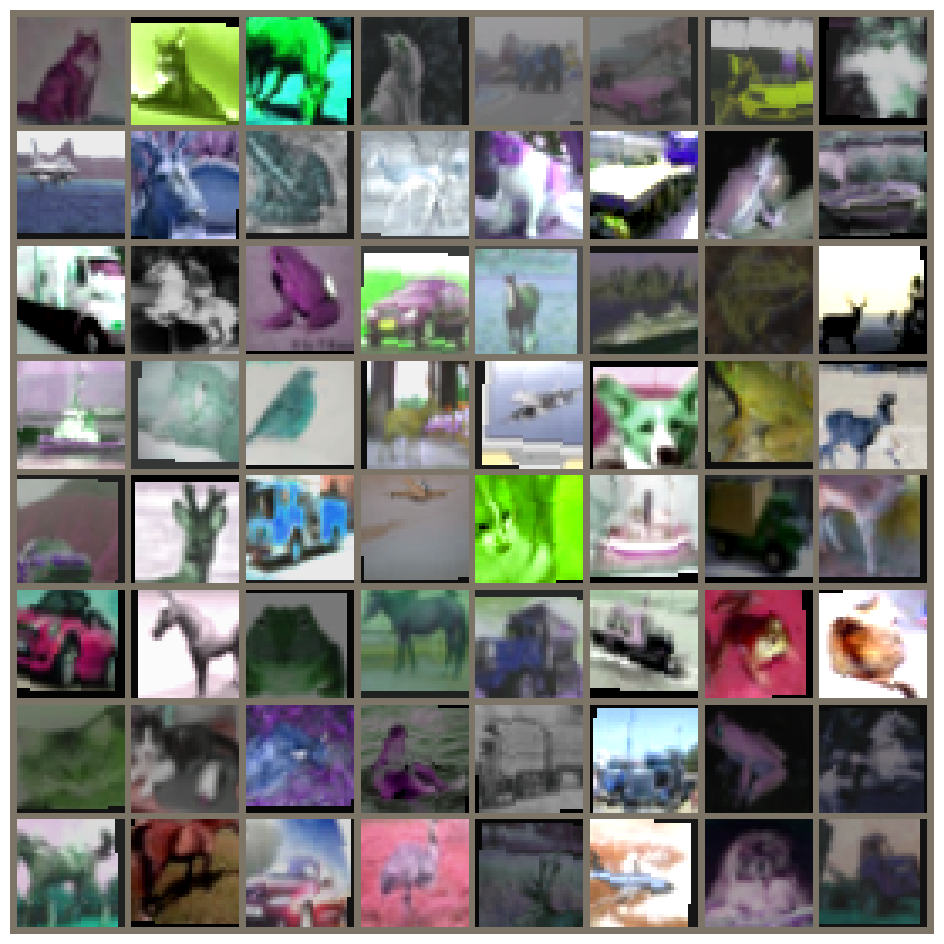

first raw classes   cat   cat horse   cat truck automobile automobile   cat
torch.Size([64, 3, 32, 32])


In [ ]:
def imshow(images, mean=mean, std=std):
    img = torchvision.utils.make_grid(images).to(device)
    img = img.transpose(2,0).transpose(0,1)
    img = (img * torch.as_tensor(std).to(device)
               + torch.as_tensor(mean).to(device) )# unnormalize
    img = img.data.cpu().numpy()

    plt.figure(figsize=(16,12))
    plt.imshow(img); plt.axis('off'); plt.show()


images, labels = next(iter(trainloader))

imshow(images)

print('first raw classes',' '.join('%5s' % names_classes[labels[j]] for j in range(BATCH_SIZE//8)))

print(images.shape)

In [ ]:
def init_weights(m):
    if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d):
        nn.init.kaiming_normal_(m.weight)
        m.bias.data.fill_(0)

model.apply(init_weights);

In [ ]:
def accuracy(y_pred, y):
    cls_pred = y_pred.argmax(1, keepdim=True)
    correct_cls = cls_pred.eq(y.view_as(cls_pred)).sum()
    acc = correct_cls.float() / y.shape[0]
    return acc

In [ ]:
LR = 0.0004
LR_PERIOD = 4
LR_DECAY  = 0.95

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

model     = model.to(device)
criterion = criterion.to(device)
metric = accuracy
scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                            step_size = LR_PERIOD,
                                            gamma     = LR_DECAY)

In [ ]:
def train(model, dataloader, optimizer, criterion, metric, device):

    epoch_loss = 0
    epoch_acc  = 0

    model.train()

    for (x, y) in tqdm(dataloader, desc="Training", leave=False):

        x = x.to(device)
        y = y.to(device)

        optimizer.zero_grad()

        y_pred = model.forward(x)

        loss = criterion(y_pred, y)
        acc  = metric( y_pred, y)

        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc  += acc.item()

    return epoch_loss / len(dataloader), epoch_acc / len(dataloader)

In [ ]:
def evaluate(model, dataloader, criterion, metric, device):

    epoch_loss = 0
    epoch_acc  = 0

    model.eval()

    with torch.no_grad():

        for (x, y) in tqdm(dataloader, desc="Evaluating", leave=False):

            x = x.to(device)
            y = y.to(device)

            y_pred = model.forward(x)

            loss = criterion(y_pred, y)
            acc  = metric( y_pred, y)

            epoch_loss += loss.item()
            epoch_acc  += acc.item()

    return epoch_loss / len(dataloader), epoch_acc / len(dataloader)

In [ ]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [ ]:
EPOCHS = 50

train_loss = torch.zeros(EPOCHS)
valid_loss = torch.zeros(EPOCHS)
train_acc  = torch.zeros(EPOCHS)
valid_acc  = torch.zeros(EPOCHS)

best_valid_loss = float('inf')
best_epoch = 0

for epoch in trange(EPOCHS, desc="Epochs"):

    start_time = time.monotonic()

    train_loss[epoch], train_acc[epoch] = train(model,
                                                trainloader,
                                                optimizer,
                                                criterion,
                                                metric,
                                                device)

    scheduler.step()

    valid_loss[epoch], valid_acc[epoch] = evaluate(model,
                                                   validloader,
                                                   criterion,
                                                   metric,
                                                   device)

    if valid_loss[epoch] < best_valid_loss:
        best_valid_loss = valid_loss[epoch]
        best_epoch = epoch
        torch.save(model.state_dict(), 'best_model.pt')

    epoch_mins, epoch_secs = epoch_time(start_time, time.monotonic())
    if epoch%2 == 1:    # print every 2 epochs:
        print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
        print(f'\tTrain Loss: {train_loss[epoch]:.3f} | Train Acc: {train_acc[epoch]*100:.2f}%')
        print(f'\t Val. Loss: {valid_loss[epoch]:.3f} |  Val. Acc: {valid_acc[epoch]*100:.2f}%')

Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/570 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/64 [00:00<?, ?it/s]

Training:   0%|          | 0/570 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 02 | Epoch Time: 1m 22s
	Train Loss: 1.915 | Train Acc: 29.27%
	 Val. Loss: 1.841 |  Val. Acc: 32.18%


Training:   0%|          | 0/570 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/64 [00:00<?, ?it/s]

Training:   0%|          | 0/570 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 04 | Epoch Time: 1m 23s
	Train Loss: 1.762 | Train Acc: 35.82%
	 Val. Loss: 1.748 |  Val. Acc: 36.87%


Training:   0%|          | 0/570 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/64 [00:00<?, ?it/s]

Training:   0%|          | 0/570 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 06 | Epoch Time: 1m 22s
	Train Loss: 1.660 | Train Acc: 39.47%
	 Val. Loss: 1.634 |  Val. Acc: 40.90%


Training:   0%|          | 0/570 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/64 [00:00<?, ?it/s]

Training:   0%|          | 0/570 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 08 | Epoch Time: 1m 21s
	Train Loss: 1.593 | Train Acc: 42.65%
	 Val. Loss: 1.614 |  Val. Acc: 42.46%


Training:   0%|          | 0/570 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/64 [00:00<?, ?it/s]

Training:   0%|          | 0/570 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 10 | Epoch Time: 1m 21s
	Train Loss: 1.539 | Train Acc: 44.85%
	 Val. Loss: 1.510 |  Val. Acc: 46.02%


Training:   0%|          | 0/570 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/64 [00:00<?, ?it/s]

Training:   0%|          | 0/570 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 12 | Epoch Time: 1m 22s
	Train Loss: 1.491 | Train Acc: 46.51%
	 Val. Loss: 1.435 |  Val. Acc: 48.70%


Training:   0%|          | 0/570 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/64 [00:00<?, ?it/s]

Training:   0%|          | 0/570 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 14 | Epoch Time: 1m 21s
	Train Loss: 1.447 | Train Acc: 48.68%
	 Val. Loss: 1.424 |  Val. Acc: 50.66%


Training:   0%|          | 0/570 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/64 [00:00<?, ?it/s]

Training:   0%|          | 0/570 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 16 | Epoch Time: 1m 21s
	Train Loss: 1.413 | Train Acc: 49.66%
	 Val. Loss: 1.390 |  Val. Acc: 51.43%


Training:   0%|          | 0/570 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/64 [00:00<?, ?it/s]

Training:   0%|          | 0/570 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 18 | Epoch Time: 1m 21s
	Train Loss: 1.380 | Train Acc: 50.80%
	 Val. Loss: 1.353 |  Val. Acc: 52.09%


Training:   0%|          | 0/570 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/64 [00:00<?, ?it/s]

Training:   0%|          | 0/570 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 20 | Epoch Time: 1m 21s
	Train Loss: 1.357 | Train Acc: 52.04%
	 Val. Loss: 1.342 |  Val. Acc: 51.74%


Training:   0%|          | 0/570 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/64 [00:00<?, ?it/s]

Training:   0%|          | 0/570 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 22 | Epoch Time: 1m 21s
	Train Loss: 1.333 | Train Acc: 52.28%
	 Val. Loss: 1.336 |  Val. Acc: 53.27%


Training:   0%|          | 0/570 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/64 [00:00<?, ?it/s]

Training:   0%|          | 0/570 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 24 | Epoch Time: 1m 21s
	Train Loss: 1.313 | Train Acc: 53.25%
	 Val. Loss: 1.296 |  Val. Acc: 54.33%


Training:   0%|          | 0/570 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/64 [00:00<?, ?it/s]

Training:   0%|          | 0/570 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 26 | Epoch Time: 1m 21s
	Train Loss: 1.303 | Train Acc: 54.04%
	 Val. Loss: 1.291 |  Val. Acc: 54.51%


Training:   0%|          | 0/570 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/64 [00:00<?, ?it/s]

Training:   0%|          | 0/570 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 28 | Epoch Time: 1m 21s
	Train Loss: 1.284 | Train Acc: 54.37%
	 Val. Loss: 1.274 |  Val. Acc: 54.79%


Training:   0%|          | 0/570 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/64 [00:00<?, ?it/s]

Training:   0%|          | 0/570 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 30 | Epoch Time: 1m 21s
	Train Loss: 1.257 | Train Acc: 55.45%
	 Val. Loss: 1.234 |  Val. Acc: 55.96%


Training:   0%|          | 0/570 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/64 [00:00<?, ?it/s]

Training:   0%|          | 0/570 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 32 | Epoch Time: 1m 21s
	Train Loss: 1.250 | Train Acc: 55.75%
	 Val. Loss: 1.239 |  Val. Acc: 56.27%


Training:   0%|          | 0/570 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/64 [00:00<?, ?it/s]

Training:   0%|          | 0/570 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 34 | Epoch Time: 1m 21s
	Train Loss: 1.234 | Train Acc: 56.16%
	 Val. Loss: 1.220 |  Val. Acc: 57.43%


Training:   0%|          | 0/570 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/64 [00:00<?, ?it/s]

Training:   0%|          | 0/570 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 36 | Epoch Time: 1m 21s
	Train Loss: 1.221 | Train Acc: 56.93%
	 Val. Loss: 1.205 |  Val. Acc: 58.00%


Training:   0%|          | 0/570 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/64 [00:00<?, ?it/s]

Training:   0%|          | 0/570 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 38 | Epoch Time: 1m 21s
	Train Loss: 1.207 | Train Acc: 57.27%
	 Val. Loss: 1.179 |  Val. Acc: 58.28%


Training:   0%|          | 0/570 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/64 [00:00<?, ?it/s]

Training:   0%|          | 0/570 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 40 | Epoch Time: 1m 21s
	Train Loss: 1.200 | Train Acc: 57.33%
	 Val. Loss: 1.193 |  Val. Acc: 57.73%


Training:   0%|          | 0/570 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/64 [00:00<?, ?it/s]

Training:   0%|          | 0/570 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 42 | Epoch Time: 1m 21s
	Train Loss: 1.191 | Train Acc: 58.15%
	 Val. Loss: 1.181 |  Val. Acc: 58.31%


Training:   0%|          | 0/570 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/64 [00:00<?, ?it/s]

Training:   0%|          | 0/570 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 44 | Epoch Time: 1m 21s
	Train Loss: 1.175 | Train Acc: 58.19%
	 Val. Loss: 1.171 |  Val. Acc: 59.18%


Training:   0%|          | 0/570 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/64 [00:00<?, ?it/s]

Training:   0%|          | 0/570 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 46 | Epoch Time: 1m 21s
	Train Loss: 1.170 | Train Acc: 58.83%
	 Val. Loss: 1.146 |  Val. Acc: 59.77%


Training:   0%|          | 0/570 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/64 [00:00<?, ?it/s]

Training:   0%|          | 0/570 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 48 | Epoch Time: 1m 21s
	Train Loss: 1.156 | Train Acc: 59.26%
	 Val. Loss: 1.169 |  Val. Acc: 59.51%


Training:   0%|          | 0/570 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/64 [00:00<?, ?it/s]

Training:   0%|          | 0/570 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 50 | Epoch Time: 1m 21s
	Train Loss: 1.145 | Train Acc: 59.72%
	 Val. Loss: 1.125 |  Val. Acc: 59.96%


После добавления Inception метрика увеличилась!

In [ ]:
torch.load('best_model.pt')

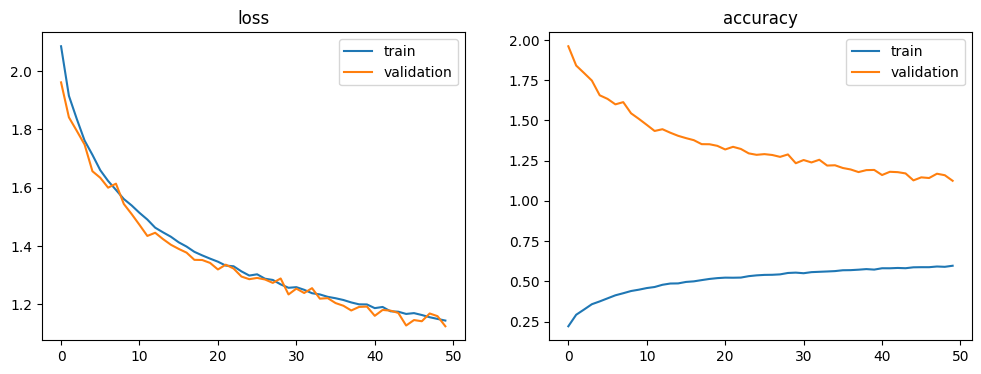

In [ ]:
def plot_results(train_loss, valid_loss, train_acc, valid_acc ):
    fig,axs = plt.subplots(1,2,figsize = (12,4))
    axs[0].plot(train_loss.cpu().numpy(), label = 'train')
    axs[0].plot(valid_loss.cpu().numpy(), label = 'validation')
    axs[0].set_title('loss')
    axs[0].legend()
    axs[1].plot(train_acc.cpu().numpy(), label = 'train')
    axs[1].plot(valid_acc.cpu().numpy(), label = 'validation')
    axs[1].set_title('accuracy')
    axs[1].legend()
    plt.show()

plot_results(train_loss, valid_loss, train_acc, valid_loss )

In [ ]:
model.load_state_dict(torch.load('best_model.pt'))
test_loss, test_acc = evaluate(model, testloader, criterion, accuracy, device)
print(f'best epoch {best_epoch}: Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

best epoch 49: Test Loss: 1.129 | Test Acc: 60.19%


С использованием блока Inception accuracy увеличилась с 54% до 60%!

In [ ]:
model.eval()

n_classes = 10
n_samples = len(testset)

class_correct = torch.zeros(n_classes)
class_total   = torch.zeros(n_classes)

labels   = []
predicts = []

with torch.no_grad():

    for x,y in tqdm(testloader):
        x = x.to(device)
        y = y.to('cpu')

        y_pred = model.forward(x).to('cpu')

        cls_pred = torch.argmax(y_pred, dim=1)

        c = (cls_pred == y).squeeze() # one-hot vector

        for i in range(x.shape[0]):
            label = y[i]
            class_correct[label] += c[i].item()
            class_total[label]   += 1

        labels.append(y)
        predicts.append(cls_pred)

labels   = torch.cat(labels, dim = 0) # make it 1d array
predicts = torch.cat(predicts, dim = 0) # make it 1d array

for i in range(n_classes):
    print('Accuracy of %5s : %2d %%' % (
        names_classes[i], 100 * class_correct[i] / class_total[i]))

  0%|          | 0/157 [00:00<?, ?it/s]

Accuracy of airplane : 68 %
Accuracy of automobile : 76 %
Accuracy of  bird : 38 %
Accuracy of   cat : 25 %
Accuracy of  deer : 45 %
Accuracy of   dog : 42 %
Accuracy of  frog : 81 %
Accuracy of horse : 73 %
Accuracy of  ship : 76 %
Accuracy of truck : 74 %


Также accuracy по классам, особенно хорошо распознает frog, ship, truck

## 2. Постарайтесь найти архитектуру улучшающую точность

Добавим в архитектру слои Dropout и также MaxPool2d, которых не было с исходной архитектуре,  чтобы улучшить рузельтат, Dropout поможет избавтиться от переобучения и выделять более общие признаки, а MaxPool2d для выделения наиболее важной информации

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class LeNetImproved(nn.Module):
    def __init__(self, in_channels, n_classes):
        super(LeNetImproved, self).__init__()

        self.conv1 = nn.Conv2d(in_channels, 32, kernel_size=5, stride=1, padding=2)
        self.bn1 = nn.BatchNorm2d(32)
        self.relu1 = nn.ReLU()

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.relu2 = nn.ReLU()
        self.dropout1 = nn.Dropout2d(p=0.3)

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.relu3 = nn.ReLU()
        self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        self.relu4 = nn.ReLU()
        self.maxpool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))

        self.fc1 = nn.Linear(256, 128)
        self.relu_fc = nn.ReLU()
        self.fc2 = nn.Linear(128, n_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.dropout1(x)

        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu3(x)
        x = self.maxpool2(x)

        x = self.conv4(x)
        x = self.bn4(x)
        x = self.relu4(x)
        x = self.maxpool3(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)

        x = self.fc1(x)
        x = self.relu_fc(x)
        x = self.fc2(x)

        return x

In [ ]:
model = LeNetImproved(3,10)

# from torchsummary import summary
summary(model, input_size = (3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]           2,432
       BatchNorm2d-2           [-1, 32, 32, 32]              64
              ReLU-3           [-1, 32, 32, 32]               0
            Conv2d-4           [-1, 64, 32, 32]          18,496
       BatchNorm2d-5           [-1, 64, 32, 32]             128
              ReLU-6           [-1, 64, 32, 32]               0
         Dropout2d-7           [-1, 64, 32, 32]               0
            Conv2d-8          [-1, 128, 32, 32]          73,856
       BatchNorm2d-9          [-1, 128, 32, 32]             256
             ReLU-10          [-1, 128, 32, 32]               0
        MaxPool2d-11          [-1, 128, 16, 16]               0
           Conv2d-12          [-1, 256, 16, 16]         295,168
      BatchNorm2d-13          [-1, 256, 16, 16]             512
             ReLU-14          [-1, 256,

In [ ]:
params = list(model.named_parameters())

# print(params)
for idx in range(len(params)):
    print(params[idx][0],'\t', params[idx][1].size())
print('\n',10*'--')
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print('Number of trainable parameters for the model: %d' % (num_params))

num_params = sum(p.numel() for p in model.parameters() )
print('Number of all parameters for the model: %d' % (num_params))

conv1.weight 	 torch.Size([32, 3, 5, 5])
conv1.bias 	 torch.Size([32])
bn1.weight 	 torch.Size([32])
bn1.bias 	 torch.Size([32])
conv2.weight 	 torch.Size([64, 32, 3, 3])
conv2.bias 	 torch.Size([64])
bn2.weight 	 torch.Size([64])
bn2.bias 	 torch.Size([64])
conv3.weight 	 torch.Size([128, 64, 3, 3])
conv3.bias 	 torch.Size([128])
bn3.weight 	 torch.Size([128])
bn3.bias 	 torch.Size([128])
conv4.weight 	 torch.Size([256, 128, 3, 3])
conv4.bias 	 torch.Size([256])
bn4.weight 	 torch.Size([256])
bn4.bias 	 torch.Size([256])
fc1.weight 	 torch.Size([128, 256])
fc1.bias 	 torch.Size([128])
fc2.weight 	 torch.Size([10, 128])
fc2.bias 	 torch.Size([10])

 --------------------
Number of trainable parameters for the model: 425098
Number of all parameters for the model: 425098


In [ ]:
def init_weights(m):
    if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d):
        nn.init.kaiming_normal_(m.weight)
        m.bias.data.fill_(0)

model.apply(init_weights);

In [ ]:
LR = 0.0004
LR_PERIOD = 4
LR_DECAY  = 0.95

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

model     = model.to(device)
criterion = criterion.to(device)
metric = accuracy
scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                            step_size = LR_PERIOD,
                                            gamma     = LR_DECAY)

In [ ]:
EPOCHS = 30

train_loss = torch.zeros(EPOCHS)
valid_loss = torch.zeros(EPOCHS)
train_acc  = torch.zeros(EPOCHS)
valid_acc  = torch.zeros(EPOCHS)

best_valid_loss = float('inf')
best_epoch = 0

for epoch in trange(EPOCHS, desc="Epochs"):

    start_time = time.monotonic()

    train_loss[epoch], train_acc[epoch] = train(model,
                                                trainloader,
                                                optimizer,
                                                criterion,
                                                metric,
                                                device)

    scheduler.step()

    valid_loss[epoch], valid_acc[epoch] = evaluate(model,
                                                   validloader,
                                                   criterion,
                                                   metric,
                                                   device)

    if valid_loss[epoch] < best_valid_loss:
        best_valid_loss = valid_loss[epoch]
        best_epoch = epoch
        torch.save(model.state_dict(), 'best_model.pt')

    epoch_mins, epoch_secs = epoch_time(start_time, time.monotonic())
    if epoch%2 == 1:    # print every 2 epochs:
        print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
        print(f'\tTrain Loss: {train_loss[epoch]:.3f} | Train Acc: {train_acc[epoch]*100:.2f}%')
        print(f'\t Val. Loss: {valid_loss[epoch]:.3f} |  Val. Acc: {valid_acc[epoch]*100:.2f}%')

Epochs:   0%|          | 0/30 [00:00<?, ?it/s]

Training:   0%|          | 0/570 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/64 [00:00<?, ?it/s]

Training:   0%|          | 0/570 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 02 | Epoch Time: 1m 29s
	Train Loss: 1.818 | Train Acc: 33.24%
	 Val. Loss: 1.768 |  Val. Acc: 36.60%


Training:   0%|          | 0/570 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/64 [00:00<?, ?it/s]

Training:   0%|          | 0/570 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 04 | Epoch Time: 1m 29s
	Train Loss: 1.611 | Train Acc: 41.67%
	 Val. Loss: 1.569 |  Val. Acc: 44.82%


Training:   0%|          | 0/570 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/64 [00:00<?, ?it/s]

Training:   0%|          | 0/570 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 06 | Epoch Time: 1m 29s
	Train Loss: 1.497 | Train Acc: 46.27%
	 Val. Loss: 1.430 |  Val. Acc: 48.67%


Training:   0%|          | 0/570 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/64 [00:00<?, ?it/s]

Training:   0%|          | 0/570 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 08 | Epoch Time: 1m 29s
	Train Loss: 1.418 | Train Acc: 49.28%
	 Val. Loss: 1.369 |  Val. Acc: 51.97%


Training:   0%|          | 0/570 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/64 [00:00<?, ?it/s]

Training:   0%|          | 0/570 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 10 | Epoch Time: 1m 29s
	Train Loss: 1.348 | Train Acc: 51.57%
	 Val. Loss: 1.244 |  Val. Acc: 55.85%


Training:   0%|          | 0/570 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/64 [00:00<?, ?it/s]

Training:   0%|          | 0/570 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 12 | Epoch Time: 1m 29s
	Train Loss: 1.293 | Train Acc: 53.97%
	 Val. Loss: 1.219 |  Val. Acc: 57.10%


Training:   0%|          | 0/570 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/64 [00:00<?, ?it/s]

Training:   0%|          | 0/570 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 14 | Epoch Time: 1m 29s
	Train Loss: 1.252 | Train Acc: 55.41%
	 Val. Loss: 1.183 |  Val. Acc: 58.38%


Training:   0%|          | 0/570 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/64 [00:00<?, ?it/s]

Training:   0%|          | 0/570 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 16 | Epoch Time: 1m 29s
	Train Loss: 1.213 | Train Acc: 57.02%
	 Val. Loss: 1.155 |  Val. Acc: 59.45%


Training:   0%|          | 0/570 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/64 [00:00<?, ?it/s]

Training:   0%|          | 0/570 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 18 | Epoch Time: 1m 29s
	Train Loss: 1.185 | Train Acc: 58.03%
	 Val. Loss: 1.195 |  Val. Acc: 57.69%


Training:   0%|          | 0/570 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/64 [00:00<?, ?it/s]

Training:   0%|          | 0/570 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 20 | Epoch Time: 1m 29s
	Train Loss: 1.153 | Train Acc: 59.43%
	 Val. Loss: 1.072 |  Val. Acc: 61.50%


Training:   0%|          | 0/570 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/64 [00:00<?, ?it/s]

Training:   0%|          | 0/570 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 22 | Epoch Time: 1m 29s
	Train Loss: 1.128 | Train Acc: 60.07%
	 Val. Loss: 1.095 |  Val. Acc: 60.92%


Training:   0%|          | 0/570 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/64 [00:00<?, ?it/s]

Training:   0%|          | 0/570 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 24 | Epoch Time: 1m 29s
	Train Loss: 1.103 | Train Acc: 61.15%
	 Val. Loss: 1.067 |  Val. Acc: 62.03%


Training:   0%|          | 0/570 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/64 [00:00<?, ?it/s]

Training:   0%|          | 0/570 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 26 | Epoch Time: 1m 29s
	Train Loss: 1.086 | Train Acc: 61.82%
	 Val. Loss: 1.109 |  Val. Acc: 60.94%


Training:   0%|          | 0/570 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/64 [00:00<?, ?it/s]

Training:   0%|          | 0/570 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 28 | Epoch Time: 1m 29s
	Train Loss: 1.064 | Train Acc: 62.63%
	 Val. Loss: 1.048 |  Val. Acc: 62.77%


Training:   0%|          | 0/570 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/64 [00:00<?, ?it/s]

Training:   0%|          | 0/570 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 30 | Epoch Time: 1m 29s
	Train Loss: 1.050 | Train Acc: 62.70%
	 Val. Loss: 0.986 |  Val. Acc: 64.88%


Метрика на val достигла 59%, что выше по сравлению с исходным вариантом на 5%

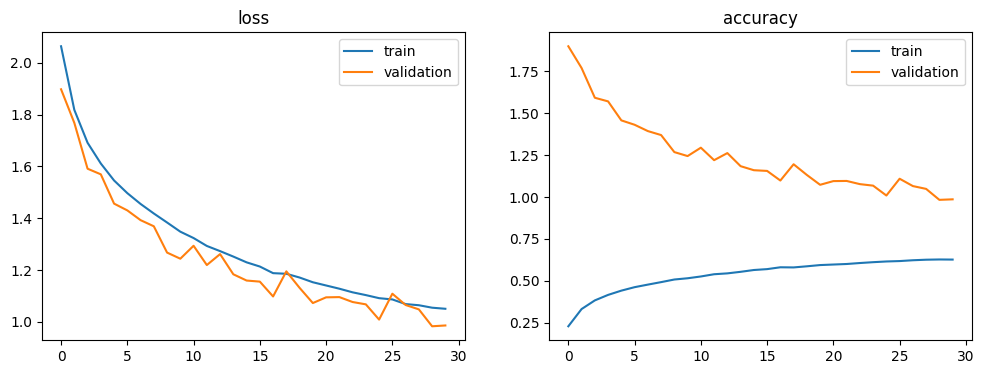

In [ ]:
def plot_results(train_loss, valid_loss, train_acc, valid_acc ):
    fig,axs = plt.subplots(1,2,figsize = (12,4))
    axs[0].plot(train_loss.cpu().numpy(), label = 'train')
    axs[0].plot(valid_loss.cpu().numpy(), label = 'validation')
    axs[0].set_title('loss')
    axs[0].legend()
    axs[1].plot(train_acc.cpu().numpy(), label = 'train')
    axs[1].plot(valid_acc.cpu().numpy(), label = 'validation')
    axs[1].set_title('accuracy')
    axs[1].legend()
    plt.show()

plot_results(train_loss, valid_loss, train_acc, valid_loss )


In [ ]:
model.load_state_dict(torch.load('best_model.pt'))
test_loss, test_acc = evaluate(model, testloader, criterion, accuracy, device)
print(f'best epoch {best_epoch}: Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

best epoch 28: Test Loss: 1.241 | Test Acc: 58.77%


Также видим улучшение метрики, значит, проведенные изменения оказали положительное влияние

In [ ]:
model.eval()

n_classes = 10
n_samples = len(testset)

class_correct = torch.zeros(n_classes)
class_total   = torch.zeros(n_classes)

labels   = []
predicts = []

with torch.no_grad():

    for x,y in tqdm(testloader):
        x = x.to(device)
        y = y.to('cpu')

        y_pred = model.forward(x).to('cpu')

        cls_pred = torch.argmax(y_pred, dim=1)

        c = (cls_pred == y).squeeze() # one-hot vector

        for i in range(x.shape[0]):
            label = y[i]
            class_correct[label] += c[i].item()
            class_total[label]   += 1

        labels.append(y)
        predicts.append(cls_pred)

labels   = torch.cat(labels, dim = 0) # make it 1d array
predicts = torch.cat(predicts, dim = 0) # make it 1d array

for i in range(n_classes):
    print('Accuracy of %5s : %2d %%' % (
        names_classes[i], 100 * class_correct[i] / class_total[i]))

  0%|          | 0/157 [00:00<?, ?it/s]

Accuracy of airplane : 61 %
Accuracy of automobile : 77 %
Accuracy of  bird : 47 %
Accuracy of   cat : 18 %
Accuracy of  deer : 42 %
Accuracy of   dog : 26 %
Accuracy of  frog : 91 %
Accuracy of horse : 53 %
Accuracy of  ship : 80 %
Accuracy of truck : 89 %


## 3. Для набора FashionMNIST

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class LeNetImproved(nn.Module):
    def __init__(self, in_channels, n_classes):
        super(LeNetImproved, self).__init__()

        self.conv1 = nn.Conv2d(in_channels, 32, kernel_size=5, stride=1, padding=2)
        self.bn1 = nn.BatchNorm2d(32)
        self.relu1 = nn.ReLU()

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.relu2 = nn.ReLU()
        self.dropout1 = nn.Dropout2d(p=0.3)

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.relu3 = nn.ReLU()
        self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        self.relu4 = nn.ReLU()
        self.maxpool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))

        self.fc1 = nn.Linear(256, 128)
        self.relu_fc = nn.ReLU()
        self.fc2 = nn.Linear(128, n_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.dropout1(x)

        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu3(x)
        x = self.maxpool2(x)

        x = self.conv4(x)
        x = self.bn4(x)
        x = self.relu4(x)
        x = self.maxpool3(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)

        x = self.fc1(x)
        x = self.relu_fc(x)
        x = self.fc2(x)

        return x

In [ ]:
model = LeNetImproved(1,10)

# from torchsummary import summary
summary(model, input_size = (1,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             832
       BatchNorm2d-2           [-1, 32, 32, 32]              64
              ReLU-3           [-1, 32, 32, 32]               0
            Conv2d-4           [-1, 64, 32, 32]          18,496
       BatchNorm2d-5           [-1, 64, 32, 32]             128
              ReLU-6           [-1, 64, 32, 32]               0
         Dropout2d-7           [-1, 64, 32, 32]               0
            Conv2d-8          [-1, 128, 32, 32]          73,856
       BatchNorm2d-9          [-1, 128, 32, 32]             256
             ReLU-10          [-1, 128, 32, 32]               0
        MaxPool2d-11          [-1, 128, 16, 16]               0
           Conv2d-12          [-1, 256, 16, 16]         295,168
      BatchNorm2d-13          [-1, 256, 16, 16]             512
             ReLU-14          [-1, 256,

In [ ]:
mean = torch.tensor([0.485, 0.456, 0.406])
std  = torch.tensor([0.229, 0.224, 0.225])

train_transforms = transforms.Compose([
                            transforms.ToTensor(),

                                      ])

test_transforms = transforms.Compose([
                           transforms.ToTensor(),
                                     ])

Загружаем данные

In [ ]:
trainset = torchvision.datasets.MNIST(root      = './data',
                                        train     = True,
                                        download  = True,
                                        transform = train_transforms)


testset = torchvision.datasets.MNIST(root      = './data',
                                       train     = False,
                                       download  = True,
                                       transform = test_transforms)


names_classes = trainset.classes
print(names_classes)

100%|██████████| 9912422/9912422 [00:00<00:00, 96740120.21it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 46024199.78it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw




100%|██████████| 1648877/1648877 [00:00<00:00, 21416003.41it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 20729628.69it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

['0 - zero', '1 - one', '2 - two', '3 - three', '4 - four', '5 - five', '6 - six', '7 - seven', '8 - eight', '9 - nine']


In [ ]:
VALID_RATIO = 0.9

n_train_examples = int(len(trainset) * VALID_RATIO)

n_valid_examples = len(trainset) - n_train_examples

if torch.cuda.is_available():
    kwarg = {'generator':torch.Generator(device='cuda')}
else:
     kwarg = {'num_workers':num_workers}

trainset, validset = data.random_split(trainset,
                                       [n_train_examples,
                                        n_valid_examples],
                                       **kwarg)

validset = copy.deepcopy(validset)
validset.dataset.transform = test_transforms

In [ ]:
print(f'Number of training examples: {len(trainset)}')
print(f'Number of validation examples: {len(validset)}')
print(f'Number of testing examples: {len(testset)}')

Number of training examples: 54000
Number of validation examples: 6000
Number of testing examples: 10000


In [ ]:
BATCH_SIZE = 64

if torch.cuda.is_available():
    kwarg = {'generator':torch.Generator(device='cuda')}
else:
     kwarg = {'num_workers':0}

trainloader = data.DataLoader(trainset,
                              shuffle=True,
                              batch_size=BATCH_SIZE,
                              **kwarg)

validloader = data.DataLoader(validset,batch_size=BATCH_SIZE, **kwarg)

testloader  = data.DataLoader(testset,batch_size=BATCH_SIZE, **kwarg)

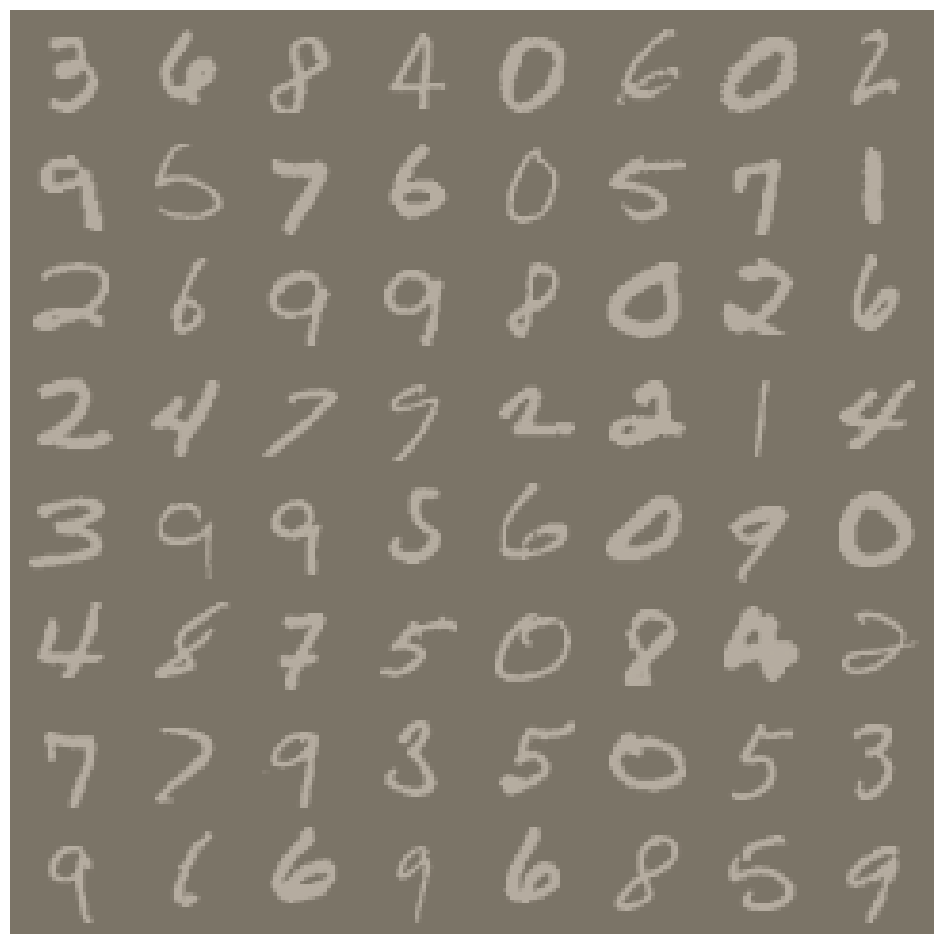

first raw classes 3 - three 6 - six 8 - eight 4 - four 0 - zero 6 - six 0 - zero 2 - two
torch.Size([64, 1, 28, 28])


In [ ]:
def imshow(images, mean=mean, std=std):
    img = torchvision.utils.make_grid(images).to(device)
    img = img.transpose(2,0).transpose(0,1)
    img = (img * torch.as_tensor(std).to(device)
               + torch.as_tensor(mean).to(device) )# unnormalize
    img = img.data.cpu().numpy()

    plt.figure(figsize=(16,12))
    plt.imshow(img); plt.axis('off'); plt.show()


images, labels = next(iter(trainloader))

imshow(images)

print('first raw classes',' '.join('%5s' % names_classes[labels[j]] for j in range(BATCH_SIZE//8)))

print(images.shape)

In [ ]:
def init_weights(m):
    if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d):
        nn.init.kaiming_normal_(m.weight)
        m.bias.data.fill_(0)

model.apply(init_weights);

In [ ]:
LR = 0.0004
LR_PERIOD = 4
LR_DECAY  = 0.95

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

model     = model.to(device)
criterion = criterion.to(device)
metric = accuracy
scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                            step_size = LR_PERIOD,
                                            gamma     = LR_DECAY)

In [ ]:
EPOCHS = 10

train_loss = torch.zeros(EPOCHS)
valid_loss = torch.zeros(EPOCHS)
train_acc  = torch.zeros(EPOCHS)
valid_acc  = torch.zeros(EPOCHS)

best_valid_loss = float('inf')
best_epoch = 0

for epoch in trange(EPOCHS, desc="Epochs"):

    start_time = time.monotonic()

    train_loss[epoch], train_acc[epoch] = train(model,
                                                trainloader,
                                                optimizer,
                                                criterion,
                                                metric,
                                                device)

    scheduler.step()

    valid_loss[epoch], valid_acc[epoch] = evaluate(model,
                                                   validloader,
                                                   criterion,
                                                   metric,
                                                   device)

    if valid_loss[epoch] < best_valid_loss:
        best_valid_loss = valid_loss[epoch]
        best_epoch = epoch
        torch.save(model.state_dict(), 'best_model.pt')

    epoch_mins, epoch_secs = epoch_time(start_time, time.monotonic())
    if epoch%2 == 1:    # print every 2 epochs:
        print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
        print(f'\tTrain Loss: {train_loss[epoch]:.3f} | Train Acc: {train_acc[epoch]*100:.2f}%')
        print(f'\t Val. Loss: {valid_loss[epoch]:.3f} |  Val. Acc: {valid_acc[epoch]*100:.2f}%')

Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 02 | Epoch Time: 0m 20s
	Train Loss: 0.139 | Train Acc: 95.99%
	 Val. Loss: 0.114 |  Val. Acc: 96.38%


Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 04 | Epoch Time: 0m 20s
	Train Loss: 0.077 | Train Acc: 97.76%
	 Val. Loss: 0.080 |  Val. Acc: 97.41%


Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 06 | Epoch Time: 0m 20s
	Train Loss: 0.056 | Train Acc: 98.29%
	 Val. Loss: 0.058 |  Val. Acc: 98.35%


Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 08 | Epoch Time: 0m 20s
	Train Loss: 0.046 | Train Acc: 98.58%
	 Val. Loss: 0.045 |  Val. Acc: 98.73%


Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 10 | Epoch Time: 0m 20s
	Train Loss: 0.037 | Train Acc: 98.86%
	 Val. Loss: 0.033 |  Val. Acc: 98.97%


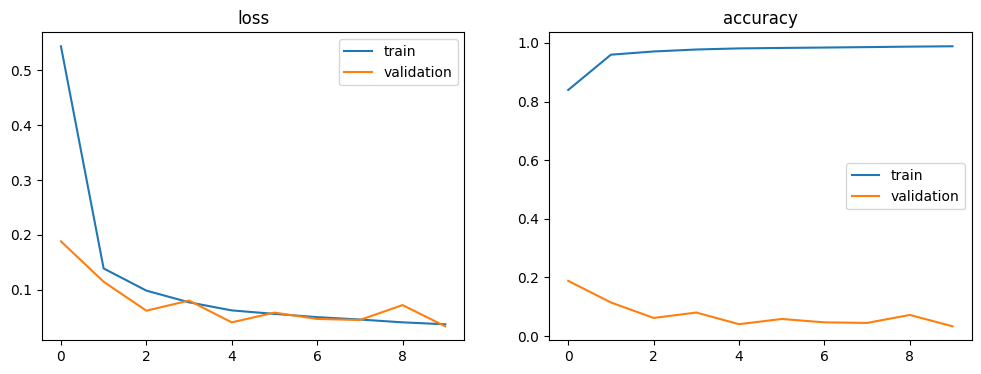

In [ ]:
def plot_results(train_loss, valid_loss, train_acc, valid_acc ):
    fig,axs = plt.subplots(1,2,figsize = (12,4))
    axs[0].plot(train_loss.cpu().numpy(), label = 'train')
    axs[0].plot(valid_loss.cpu().numpy(), label = 'validation')
    axs[0].set_title('loss')
    axs[0].legend()
    axs[1].plot(train_acc.cpu().numpy(), label = 'train')
    axs[1].plot(valid_acc.cpu().numpy(), label = 'validation')
    axs[1].set_title('accuracy')
    axs[1].legend()
    plt.show()

plot_results(train_loss, valid_loss, train_acc, valid_loss )


In [ ]:
model.load_state_dict(torch.load('best_model.pt'))
test_loss, test_acc = evaluate(model, testloader, criterion, accuracy, device)
print(f'best epoch {best_epoch}: Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

best epoch 9: Test Loss: 0.035 | Test Acc: 98.89%


Достигли точности 98% на данных MNIST!!